# NMF
- NMF (Non-negative Matrix Factorization) is a matrix factorization technique commonly used for unsupervised learning in data science and machine learning. NMF decomposes a non-negative matrix into two non-negative matrices: a basis matrix and a coefficient matrix. The basis matrix represents the fundamental features or patterns in the data, while the coefficient matrix represents the weights of those features for each observation.

- NMF is important because it can be used for dimensionality reduction, feature extraction, and clustering, among other tasks. It is especially useful when dealing with high-dimensional data or data with sparse features. For example, it has been successfully applied in areas such as image processing, text mining, and bioinformatics.

- Performance of NMF is typically evaluated using a metric such as reconstruction error or sparsity. Reconstruction error measures how well the original matrix can be approximated by the product of the basis and coefficient matrices. Sparsity measures the degree to which the basis and coefficient matrices contain mostly zeros. A good NMF model will have a low reconstruction error and high sparsity.

- Interpreting the results of NMF involves examining the basis matrix to understand the fundamental features or patterns in the data. Each row of the basis matrix corresponds to a feature or pattern, and the columns correspond to the original dimensions or variables of the data. The coefficient matrix can be used to understand how strongly each observation is associated with each feature or pattern.


# My concern with the NMF model is that the topic’s “top 10-word” weights add to a number greater than 1. From my research, I believe the weights should add to one.

- If the top word weights for a given topic add up to a number greater than 1, it may be a result of normalization not being applied properly. One common normalization technique for NMF is to divide each row of the coefficient matrix (which represents the weight of each topic for each document) by the sum of its elements. This ensures that the weights for each document sum to 1.

- To address the issue of the top word weights for a given topic summing to a number greater than 1, you could try normalizing the weights for each topic to ensure that they sum to 1. One way to do this is to divide each weight by the sum of all the weights for that topic.

- The NMF weights for each topic are also added to a dataframe nmf_weights_df, which has one row for each topic and one column for each word in the vocabulary. Each element in the dataframe represents the weight of that word in that topic. The weights are normalized so that they sum to 1 for each topic.

In [1]:
! pip install --quiet --upgrade nltk gensim wordcloud > /dev/null

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('all', quiet=True)

True

In [3]:
# importing the libraries
import pandas as pd
import pickle
import re
import string
import numpy as np
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from pprint import pprint
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")


In [4]:
import os

# Identify the working directory and data files
working_directory = "35-LDA_and_NMF_finalized"

# Create the working directory if needed
try:
    os.makedirs(working_directory, exist_ok=True)
except OSError as error:
    print(f"Error creating {working_directory}: {error}")

In [5]:
# loading the data
df = pd.read_pickle("./21-Preprocess-Combined-Data-v2/dataframe.pickle")

In [6]:
df.head()

,ROW_ID,FOI_TEXT,DEVICE_PROBLEM_CODE,DEVICE_PROBLEM_TEXT,GENERIC_NAME,DEVICE_REPORT_PRODUCT_CODE,UDI-DI,UDI-PUBLIC,DATE_OF_EVENT,REPORTER_OCCUPATION_CODE,REPORT_DATE,EVENT_LOCATION,SOURCE_TYPE,TOKENIZED_TEXT,NOPUNCT_TEXT,NOSTOPWORDS_TEXT,NODIGITS_TEXT,POS_TEXT,LEMMATIZED_TEXT,STEMMED_TEXT
0,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,,,07/30/2020,000,,I,CONSUMER,"[it, was, reported, that, the, transmitter, lo...","[it, was, reported, that, the, transmitter, lo...","[reported, transmitter, lost, connection, pump...","[reported, transmitter, lost, connection, pump...","[(reported, VBN), (transmitter, NN), (lost, VB...","[report, transmitter, lose, connection, pump, ...","[report, transmitt, lost, connect, pump, great..."
1,1426265,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,06/05/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, produ...","[report, signal, loss, one, hour, occur, produ..."
2,2609625,IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...,1435,No Device Output,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,10/05/2020,000,,I,CONSUMER,"[it, was, reported, that, transmitter, failed,...","[it, was, reported, that, transmitter, failed,...","[reported, transmitter, failed, error, occurre...","[reported, transmitter, failed, error, occurre...","[(reported, VBN), (transmitter, NN), (failed, ...","[report, transmitter, fail, error, occur, data...","[report, transmitt, fail, error, occur, data, ..."
3,2813837,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,10/23/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, revie...","[report, signal, loss, one, hour, occur, revie..."
4,1337517,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,05/25/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, produ...","[report, signal, loss, one, hour, occur, produ..."


In [7]:
# create a DataFrame for the sentences
sentences_df = pd.DataFrame(
    columns=[
        'SENTENCE_ID',
        'SENTENCE', 
        'ROW_ID', 
        'FOI_TEXT', 
        'DEVICE_PROBLEM_CODE',
        'DEVICE_PROBLEM_TEXT'
    ]
)

# Iterate over every row in the FOI_TEXT DataFrame
# and create a new dataframe with a row for each sentence.
# Each row will have a sentence, the orginal ROW_ID, and the
# FOI_TEXT that it came from along with the DEVICE_PROBLEM_CODE and
# DEVICE_PROBLEM_TEXT from the orginal FOI_TEXT
sentence_counter = 0

for index, row in df.iterrows():
    for sentence in nltk.sent_tokenize(row['FOI_TEXT']):
        sentence_data = {
            'SENTENCE': sentence,
            'SENTENCE_ID': sentence_counter,
            'ROW_ID': row['ROW_ID'], 
            'FOI_TEXT': row['FOI_TEXT'], 
            'DEVICE_PROBLEM_CODE': row['DEVICE_PROBLEM_CODE'],
            'DEVICE_PROBLEM_TEXT': row['DEVICE_PROBLEM_TEXT']
        }
        sentences_df = sentences_df.append(sentence_data, ignore_index=True)
        sentence_counter = sentence_counter + 1        

In [8]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

punctuations = set(string.punctuation)

def process_sentence(sentence):
    # Lowercase the sentence
    sentence = sentence.lower()

    # Remove any words that start with a digit
    sentence = re.sub(r'\b\d\w*\b', '', sentence)

    # Remove punctuation
    sentence_tokens = sentence.split()
    sentence_tokens = [token.translate(str.maketrans("", "", string.punctuation)) for token in sentence_tokens]

    # Remove stopwords
    sentence_tokens = [token for token in sentence_tokens if token not in stop_words]
    
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in sentence_tokens]
    
    # Rebuild the sentence
    sentence = ' '.join(lemmatized_tokens)

    return sentence

sentences_df['PROCESSED_SENTENCE'] = sentences_df['SENTENCE'].apply(process_sentence)

In [9]:
sentences_df['PROCESSED_SENTENCE']

0        report transmitter lose connection pump greate...
1            transmitter ultimately regain connection pump
2           additional patient event information available
3                        report signal loss one hour occur
4                          product data provide evaluation
                               ...                        
25681                    report signal loss one hour occur
25682                              data receive evaluation
25683    however allege product present within investig...
25684    confirmation allegation probable cause could d...
25685                   injury medical intervention report
Name: PROCESSED_SENTENCE, Length: 25686, dtype: object

In [10]:
# Tokenizing the text data in Processed_sentences
processed_docs = sentences_df['PROCESSED_SENTENCE'].apply(lambda x: word_tokenize(x))

In [11]:
# Removing the stop words
stop_words = set(nltk.corpus.stopwords.words('english'))
processed_docs = [[word for word in doc if word.lower() not in stop_words] for doc in processed_docs]

In [12]:
# Creating a dictionary of words and their frequency
dictionary = corpora.Dictionary(processed_docs)

# Filtering out words that appear in less than 5 documents, and more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Creating bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [13]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

In [14]:
# Topics range
min_topics = 1
max_topics = 50
step = 1

# The number of top words per topic
num_top_words = 10

# Initial random state
random_state = 42

In [15]:
# Converting the preprocessed sentences to a list
processed_sentences = sentences_df['PROCESSED_SENTENCE'].tolist()

# Creating a TfidfVectorizer object
vectorizer = TfidfVectorizer(stop_words='english')
vectorized_sentences = vectorizer.fit_transform(processed_sentences)

# Creating an empty dataframe to hold the NMF weights
nmf_weights_df = pd.DataFrame()

coherence_scores = []
nmf_model_collection = []
nmf_result_collection = []
coherence_model_collection = []

for k in range(step, max_topics + 1, step):
    nmf_model_collection.append(NMF(
        n_components=k, 
        random_state=random_state, 
        init='nndsvda'
    ))
    
    # Fit the model to the data
    nmf_result_collection.append(nmf_model_collection[-1].fit_transform(vectorized_sentences))
    
    vocab = vectorizer.get_feature_names_out()
    
    topics = []
    
    for topic_index, topic in enumerate(nmf_model_collection[-1].components_):
        top_words = [vocab[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append(top_words)
        
        # Adding the NMF weights to the dataframe
        nmf_weights = pd.DataFrame(topic).T.add_prefix('Topic_')
        nmf_weights['k'] = k
        nmf_weights_df = nmf_weights_df.append(nmf_weights)
        
    # Normalizing the NMF weights so they sum to 1
    nmf_weights_df.iloc[:, :-1] = nmf_weights_df.iloc[:, :-1].div(
        nmf_weights_df.iloc[:, :-1].sum(axis=1), 
        axis=0
    )
    
    # splitting each sentence into a list of words
    texts = sentences_df['PROCESSED_SENTENCE'].apply(lambda x: nltk.word_tokenize(x)).tolist()
    
    # Creating a dictionary from the words
    dictionary = corpora.Dictionary(texts)
    
    # Creating a bag-of-words representation of the corpus
    corpus = [dictionary.doc2bow(word) for word in texts]
    
    coherence_model_collection.append(CoherenceModel(
                        topics=topics, 
                        texts=texts, 
                        dictionary=dictionary, 
                        coherence='c_v'
                      ))
    
    coherence_scores.append(coherence_model_collection[-1].get_coherence())
    
    print(f"Number of topics: {k}, Coherence Score: {coherence_scores[-1]}")

# Creating DataFrame of number of topics and corresponding coherence score
coherence_scores_df = pd.DataFrame(
    {'k': range(min_topics, max_topics+1), 
     'coherence_score': coherence_scores}
)

Number of topics: 1, Coherence Score: 0.23771367421853667
Number of topics: 2, Coherence Score: 0.29587084719730417
Number of topics: 3, Coherence Score: 0.3658700373414378
Number of topics: 4, Coherence Score: 0.353839876172447
Number of topics: 5, Coherence Score: 0.36269159010791824
Number of topics: 6, Coherence Score: 0.394495350476984
Number of topics: 7, Coherence Score: 0.42419626592993914
Number of topics: 8, Coherence Score: 0.4202628244314765
Number of topics: 9, Coherence Score: 0.4077646887063782
Number of topics: 10, Coherence Score: 0.3960908607019562
Number of topics: 11, Coherence Score: 0.3816411291125107
Number of topics: 12, Coherence Score: 0.4230375395895114
Number of topics: 13, Coherence Score: 0.41728193479156456
Number of topics: 14, Coherence Score: 0.42523368207379025
Number of topics: 15, Coherence Score: 0.415689010387961
Number of topics: 16, Coherence Score: 0.4074303855348781
Number of topics: 17, Coherence Score: 0.40717165968929303
Number of topics: 1

In [16]:
coherence_scores_df

,k,coherence_score
0,1,0.237714
1,2,0.295871
2,3,0.365870
3,4,0.353840
4,5,0.362692
5,6,0.394495
6,7,0.424196
7,8,0.420263
8,9,0.407765
9,10,0.396091


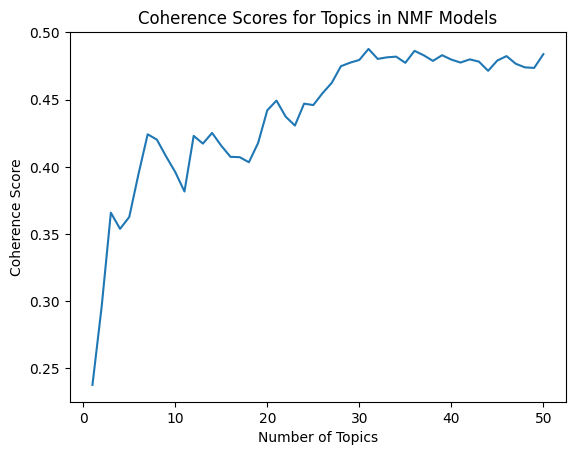

In [17]:
# Plotting the coherence score for each number of topics
k = range(min_topics, max_topics+1)
plt.plot(k, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title('Coherence Scores for Topics in NMF Models')
plt.show()

In [22]:
# Select the best hyper parameters
max_score_index = coherence_scores_df["coherence_score"].idxmax()
print(max_score_index)

30


In [23]:
# Select the row with the highest score
max_row = coherence_scores_df.loc[
    coherence_scores_df['coherence_score'].idxmax()
]

selected_k = max_row['k']
selected_score = max_row['coherence_score']

# print the value of num_topics with the highest coherence score
print(f"Index for the highest coherence score              : {max_score_index}")
print(f"Selected num_topics for the highest coherence score: {selected_k}")
print(f"Selected score for the highest coherence score     : {selected_score}")

Index for the highest coherence score              : 30
Selected num_topics for the highest coherence score: 31.0
Selected score for the highest coherence score     : 0.48773471462924217


# Analysis with selected_k

In [24]:
topics = []

for topic_index, topic in enumerate(nmf_model_collection[max_score_index].components_):
    top_words = [vocab[i] for i in topic.argsort()[:-num_top_words - 1:-1]]

    topics.append(top_words)

    # Adding the NMF weights to the dataframe
    nmf_weights = pd.DataFrame(topic).T.add_prefix('Topic_')
    nmf_weights['k'] = selected_k
    nmf_weights_df = nmf_weights_df.append(nmf_weights)

# Normalizing the NMF weights so they sum to 1
nmf_weights_df.iloc[:, :-1] = nmf_weights_df.iloc[:, :-1].div(
    nmf_weights_df.iloc[:, :-1].sum(axis=1), 
    axis=0
)

# Creating a dataframe of the top 10 words for each topic
top_words_df = pd.DataFrame(topics, columns=[f'word_{i}' for i in range(num_top_words)])
top_words_df

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
0,injury,intervention,medical,report,adverse,impact,occur,submit,wire,completion
1,probable,determine,cause,data,allegation,defective,potential,misuse,signal,patient
2,hour,signal,loss,occur,report,failure,reportable,base,pair,intermittent
3,confirm,allegation,data,undetermined,message,addition,greater,problem,end,investigate
4,provide,evaluation,data,product,receive,investigation,pending,supplemental,submit,complete
5,fail,error,transmitter,occur,report,customer,receive,reportable,base,new
6,review,log,share,window,investigation,perform,loss,signal,connection,allege
7,additional,patient,event,available,information,close,misuse,reportable,base,potential
8,evaluate,data,product,undetermined,investigation,greater,message,support,complete,ambiguity
9,supplemental,submit,relevant,new,available,information,report,evaluation,perform,completion


In [25]:
# Joining the coherence scores dataframe with the top words dataframe
coherence_scores_df = coherence_scores_df.merge(top_words_df, left_index=True, right_index=True)
coherence_scores_df

,k,coherence_score,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
0,1,0.237714,injury,intervention,medical,report,adverse,impact,occur,submit,wire,completion
1,2,0.295871,probable,determine,cause,data,allegation,defective,potential,misuse,signal,patient
2,3,0.365870,hour,signal,loss,occur,report,failure,reportable,base,pair,intermittent
3,4,0.353840,confirm,allegation,data,undetermined,message,addition,greater,problem,end,investigate
4,5,0.362692,provide,evaluation,data,product,receive,investigation,pending,supplemental,submit,complete
5,6,0.394495,fail,error,transmitter,occur,report,customer,receive,reportable,base,new
6,7,0.424196,review,log,share,window,investigation,perform,loss,signal,connection,allege
7,8,0.420263,additional,patient,event,available,information,close,misuse,reportable,base,potential
8,9,0.407765,evaluate,data,product,undetermined,investigation,greater,message,support,complete,ambiguity
9,10,0.396091,supplemental,submit,relevant,new,available,information,report,evaluation,perform,completion


In [26]:
nmf_weights_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_812,Topic_813,Topic_814,Topic_815,Topic_816,Topic_817,Topic_818,Topic_819,Topic_820,k
0,2.900162e-07,0.000027,5.606506e-09,0.000002,5.026840e-07,3.717690e-06,2.454243e-07,0.000071,1.770630e-08,0.000002,...,0.000425,0.000055,1.471815e-06,2.694607e-06,1.941491e-07,3.074581e-08,8.039155e-09,1.459318e-06,0.000588,1.0
0,2.889639e-07,0.000026,4.265018e-09,0.000000,1.617504e-07,3.757521e-06,2.270804e-07,0.000071,1.710983e-08,0.000002,...,0.000428,0.000055,1.478483e-06,2.708966e-06,1.844629e-07,2.989320e-08,8.048529e-09,1.445861e-06,0.000590,2.0
0,8.946238e-08,0.000027,4.444425e-08,0.000282,2.081707e-05,6.447235e-10,6.197463e-07,0.000016,2.363676e-08,0.000002,...,0.000032,0.000011,2.633276e-07,6.684061e-07,3.547672e-07,3.446561e-08,1.589550e-09,6.316192e-07,0.000130,2.0
0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,3.644672e-06,2.660528e-08,0.000062,4.221765e-09,0.000001,...,0.000206,0.000020,1.505645e-06,3.309152e-06,2.303632e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000328,3.0
0,0.000000e+00,0.000019,4.457408e-08,0.000296,2.166158e-05,0.000000e+00,6.074883e-07,0.000012,2.111648e-08,0.000002,...,0.000000,0.000002,1.802506e-07,6.899900e-07,3.228174e-07,2.517076e-08,0.000000e+00,0.000000e+00,0.000046,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000000e+00,0.000000,0.000000e+00,0.000000,2.659351e-05,1.259882e-05,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.826733e-07,0.000000e+00,0.000000,31.0
0,1.520916e-04,0.000000,1.676971e-06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.001495,9.445477e-07,0.000000,...,0.000000,0.000382,4.082184e-04,0.000000e+00,4.089220e-06,0.000000e+00,3.108058e-08,0.000000e+00,0.000000,31.0
0,0.000000e+00,0.000000,0.000000e+00,0.000000,3.406933e-06,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000039,0.000000e+00,1.466349e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,31.0
0,0.000000e+00,0.000000,9.454669e-06,0.000000,7.219061e-06,0.000000e+00,0.000000e+00,0.000000,2.989549e-06,0.000000,...,0.000000,0.000000,5.757587e-05,5.264278e-06,4.348908e-05,3.518742e-06,4.967798e-06,0.000000e+00,0.000000,31.0


In [27]:
# Checking if the sum of all coefficients of a NMF model for each topic sums to greater than 1 or not
print(np.allclose(nmf_weights_df.iloc[:, :-1].sum(axis=1), 1.0))

True


In [33]:
residual_data = []

selected_k = int(selected_k)

A = vectorized_sentences # Original Matrix (after tf-idf vectorization is applied)
W = nmf_model_collection[selected_k].components_ # Component matrix
H = nmf_model_collection[selected_k].fit_transform(vectorized_sentences) # Features matrix

# Get the residuals for each document
#r = np.zeros(A.shape[0])
r = np.zeros(selected_k + 1)

for row in range(1, selected_k + 1):
    # 'fro' here means we are using the Frobenium norm as the distance metric
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')
    residual_data.append([row, r[row]])

# Create a dataframe from the residual data list
residual_df = pd.DataFrame(residual_data, columns=['k', 'r'])

In [34]:
residual_df = residual_df.sort_values(by='r').reset_index(drop=True)

In [35]:
residual_df

,k,r
0,23,0.001487
1,15,0.001487
2,6,0.001487
3,10,0.001487
4,29,0.001487
5,5,0.013562
6,24,0.015793
7,11,0.015793
8,16,0.015793
9,3,0.015793


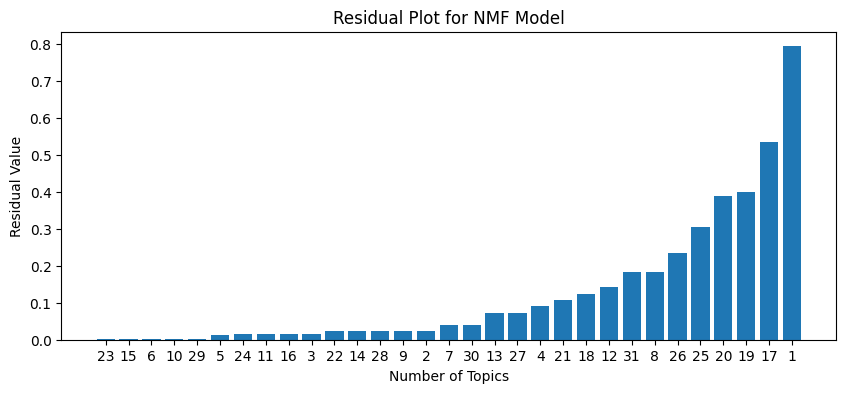

In [36]:
plt.figure(figsize=(10, 4))
plt.bar(residual_df.index, residual_df['r'])
plt.xticks(residual_df.index, residual_df['k'])
plt.xlabel('Number of Topics')
plt.ylabel('Residual Value')
plt.title('Residual Plot for NMF Model')
plt.show()